In [1]:
%matplotlib inline
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# Mobius SimplyP tutorial: model calibration and uncertainty estimation

This notebook illustrates how to perform auto-calibration and uncertainty analysis using the Mobius Python interface and the [SimplyP](https://github.com/LeahJB/SimplyP) model.

## 1. Compile SimplyP, or obtain a pre-compiled version

To interact with the Mobius version of SimplyP via Python, you first a need to compile the model to a dynamic linked library (`.dll`; for Windows) or a shared library (`.so`; for Linux). On Windows, this will involve installing the g++ compiler and adding it to your system path - see [here](https://github.com/NIVANorge/Mobius#quick-start-guide) for details. On Linux, g++ should already be available.

With the compiler installed, download or clone the Mobius repository ([here](https://github.com/NIVANorge/Mobius#quick-start-guide)), then open a `cmd` prompt, `cd` into 

    Mobius/Applications/SimplyP

and either run `compile_dll.bat` (on Windows) or `chmod +x compile_dll.sh` followed by `compile_dll.sh` (on Linux). This will create a file named `simplyp.dll` (on Windows) or `simplyp.so` (on Linux). Th model can then be imported into a Python script or Jupyter notebook, as shown below.

If this is daunting, feel free to get in touch and we can provide pre-compiled models (contact details on the Mobius homepage).

In [2]:
# Initialise wrapper and test datasets
wrapper_fpath = (r'../mobius.py')
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('../../Applications/SimplyP/simplyp.so')

# Calibration and uncertainty functions
calib_fpath = (r'../mobius_calib_uncert_lmfit.py')
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

## 2. Load observed datasets and model structure

The Mobius repositiory contains example data from two catchments: the Tarland Burn in North-eastern Scotland, and the Morsa catchment in South-eastern Norway. **The descriptive text in this notebook assumes you're working through the Morsa example**, but code is provided for both. Examples of the input data format can be found in e.g. `Applications/SimplyP/Morsa`.

In [3]:
# Choose the catchment to work with for this example ('Morsa' or 'Tarland')
catchment = 'Tarland' 

# Load dataset
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/%s/%sParameters_v0-3.dat' % (catchment, catchment),
                                                          '../../Applications/SimplyP/%s/%sInputs.dat' % (catchment, catchment))

## 3. Link observed and simulated datasets

In order to assess model performance, we need to be able to compare simulated values to observations. The code below links five simulated data series (Q, SS, TP, TDP and PP) to the relevant observed datasets (as defined in the Mobius `dataset` object).

**Note:** "Kure" is a monitoring location in the Morsa catchment, which was used as an "index" when setting up the SimplyP model. The `comparisons` list below contains five tuples, each mapping a simulated dataset in the model to an observed data series. The names of the observed data series should match those present in the input `.dat` file.

**To do**

 * Add wrapper functionality to get a list of possible comparisons directly from the dataset object? 

In [4]:
# List of simulated and observed variables to investigate for Morsa
# comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'], 'Observed Q', []),
#                ('Reach suspended sediment concentration', ['Kure'], 'Observed SS at Kure', []),
#                ('Reach TP concentration', ['Kure'], 'Observed TP at Kure', []),
#                ('Reach TDP concentration', ['Kure'], 'Observed TDP at Kure', []),
#                ('Reach PP concentration', ['Kure'], 'Observed PP at Kure', []),            
#               ]

# List of simulated and observed variables to investigate for Tarland
comparisons = [('Reach flow (daily mean, cumecs)', ['Coull'], 'observed Q', []),
               ('Reach suspended sediment concentration', ['Coull'], 'observed SS', []),
               ('Reach TDP concentration', ['Coull'], 'observed TDP', []),
               ('Reach PP concentration', ['Coull'], 'observed PP', []),            
              ]

## 4. Manual calibration

The original data files (`MorsaParameters_v0-3.dat` and `MorsaInputs.dat`) used to create this Mobius `dataset` include deafult values and plausible ranges for each model parameter. The code below lists these default values for all the `double` parameters defined in the model (these are the ones available for calibration).

In [5]:
# Get parameter values defined in 'dataset'
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

name           unit  \
0                                            Latitude              °   
1              Initial snow depth as water equivalent             mm   
2                      Degree-day factor for snowmelt      mm/°C/day   
3   Proportion of precipitation that contributes t...  dimensionless   
4                           PET multiplication factor  dimensionless   
5                                 Soil field capacity             mm   
6                                      Baseflow index  dimensionless   
7                           Groundwater time constant           days   
8                            Minimum groundwater flow         mm/day   
9                               Manning's coefficient      s/(m^1/3)   
10                                     Catchment area           km^2   
11                                       Reach length              m   
12                                        Reach slope            m/m   
13                             Initial in-stream flow          m^3/s   
14                           Soil water time constant           days   
15                           Soil water time constant           days   
16                           Soil water time constant           days   
17                               Land use proportions  dimensionless   
18                               Land use proportions  dimensionless   
19                               Land use proportions  dimensionless   
20                Reach sediment input scaling factor         kg/m^3   
21              Sediment input non-linear coefficient  dimensionless   
22                   Proportion of spring grown crops  dimensionless   
23             Mean slope of land in the subcatchment              °   
24             Mean slope of land in the subcatchment              °   
25             Mean slope of land in the subcatchment              °   
26                            Vegetation cover factor  dimensionless   
27                            Vegetation cover factor  dimensionless   
28                            Vegetation cover factor  dimensionless   
29                      Reduction of load in sediment  dimensionless   
30                      Reduction of load in sediment  dimensionless   
31                      Reduction of load in sediment  dimensionless   
32                                   Soil mass per m2         kg/m^2   
33                   Phosphorous sorption coefficient          mm/kg   
34            Net annual P input to agricultural soil     kg/ha/year   
35         Net annual P input to newly-converted soil     kg/ha/year   
36                      Groundwater TDP concentration           mg/l   
37                    Particulate P enrichment factor  dimensionless   
38                                       SRP fraction  dimensionless   
39                          Reach effluent TDP inputs         kg/day   
40      Initial soil water TDP concentration and EPC0           mg/l   
41      Initial soil water TDP concentration and EPC0           mg/l   
42      Initial soil water TDP concentration and EPC0           mg/l   
43                       Initial total soil P content          mg/kg   
44                       Initial total soil P content          mg/kg   
45                       Initial total soil P content          mg/kg   
46          Land use proportions from newly-converted  dimensionless   
47          Land use proportions from newly-converted  dimensionless   
48          Land use proportions from newly-converted  dimensionless   

                          index  min_value  initial_value   max_value  
0                            ()  -90.00000      59.600000        90.0  
1                            ()    0.00000       0.000000     50000.0  
2                            ()    0.00000       2.740000         5.0  
3                            ()    0.00000       0.020000         1.0  
4                            ()    0.00000       1.000000         1.0  
5               

Note the `index` column in this dataframe, which specifies how each parameter varies within the model structure. For example, the `Vegetation cover factor` takes different values for different land use classes, while the `Mean slope of land` parameters vary both by land class and river reach.

For this particular dataset, the default values in the `initial_value` column were informed by manual calibration using the [MobiView GUI application](https://github.com/NIVANorge/Mobius#the-mobiview-graphical-user-interface). We can easily run the model with these values and assess the goodness-of-fit. The functions below produce one plot and one set of summary statistics for each dataset in `comparisons`.


Goodness of fit for Reach flow (daily mean, cumecs) [Coull] vs observed Q []:
Mean error (bias): 0.032003
Mean absolute error: 0.146508
Root mean square error: 0.215477
Nash-Sutcliffe coefficient: 0.689684
Number of observations: 479


Goodness of fit for Reach suspended sediment concentration [Coull] vs observed SS []:
Mean error (bias): 2.613284
Mean absolute error: 11.751877
Root mean square error: 31.812637
Nash-Sutcliffe coefficient: 0.131608
Number of observations: 397


Goodness of fit for Reach TDP concentration [Coull] vs observed TDP []:
Mean error (bias): 0.000501
Mean absolute error: 0.007775
Root mean square error: 0.011022
Nash-Sutcliffe coefficient: 0.128392
Number of observations: 398


Goodness of fit for Reach PP concentration [Coull] vs observed PP []:
Mean error (bias): 0.007013
Mean absolute error: 0.021509
Root mean square error: 0.037783
Nash-Sutcliffe coefficient: 0.017804
Number of observations: 383



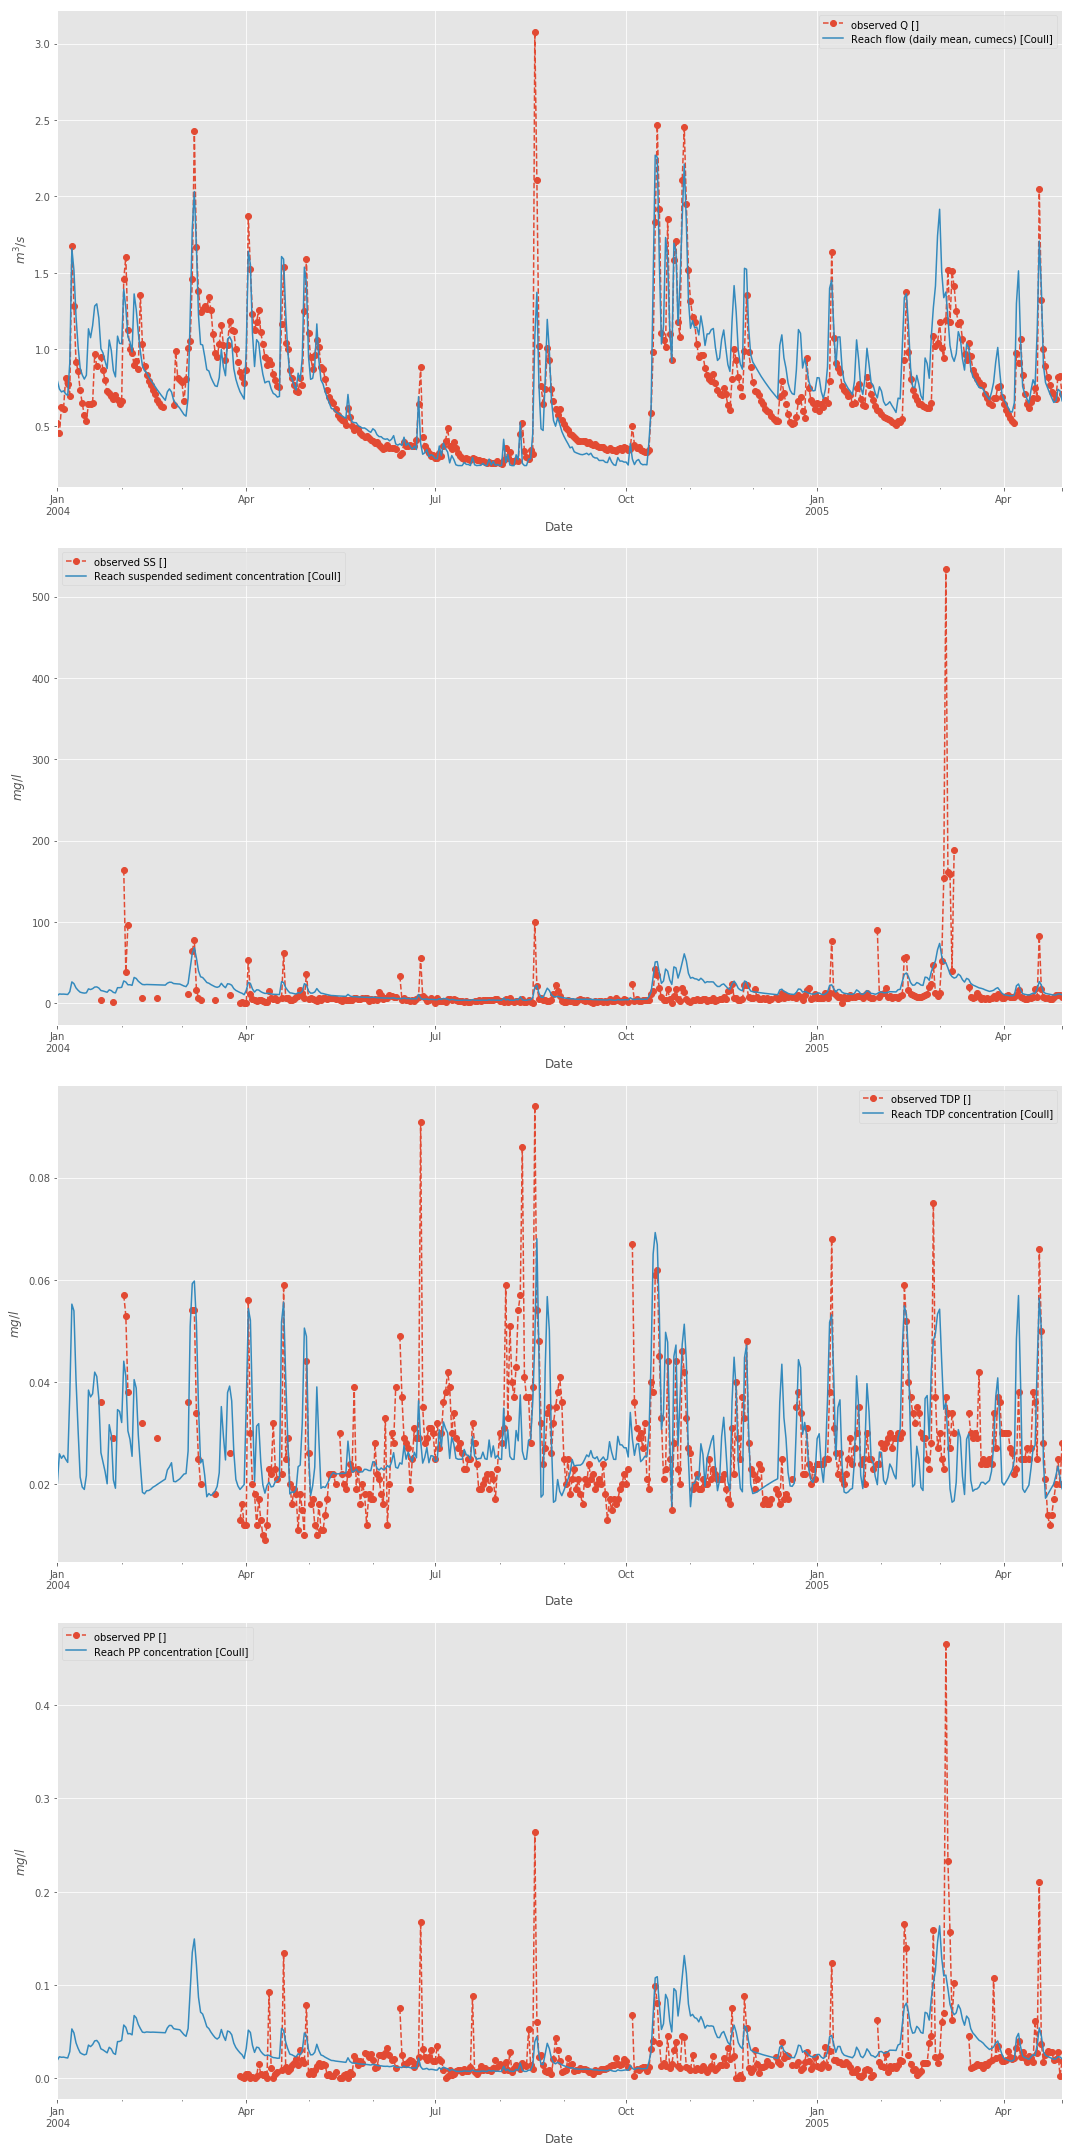

In [6]:
# Plot results from manual calibration
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

## 5. Auto-calibration

### 5.1. Choose parameters to calibrate

Parameter values should be informed by system knowledge wherever possible. In this example, we will choose to calibrate a sub-set of model parameters that are poorly constrained.

The code below selects **11 parameters** for further investigation.

**Note:** Several Pandas methods can be used to subset `param_df`. The approach illustrated below is simple, but rather rough and error-prone.  Consider using e.g. [`df.query`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) instead to explicitly select parameters by name and index.

In [7]:
# Get params to be calibrated for Morsa
#calib_df = param_df.loc[[2, 3, 4, 6, 7, 16, 22, 42, 38, 39, 41]].reset_index(drop=True)

# Get params to be calibrated for Tarland
calib_df = param_df.loc[[2, 3, 4, 6, 7, 16, 20, 40, 36, 37, 39]].reset_index(drop=True)
calib_df

name           unit  \
0                      Degree-day factor for snowmelt      mm/°C/day   
1   Proportion of precipitation that contributes t...  dimensionless   
2                           PET multiplication factor  dimensionless   
3                                      Baseflow index  dimensionless   
4                           Groundwater time constant           days   
5                            Soil water time constant           days   
6                 Reach sediment input scaling factor         kg/m^3   
7       Initial soil water TDP concentration and EPC0           mg/l   
8                       Groundwater TDP concentration           mg/l   
9                     Particulate P enrichment factor  dimensionless   
10                          Reach effluent TDP inputs         kg/day   

              index  min_value  initial_value  max_value  
0                ()       0.00           2.74        5.0  
1                ()       0.00           0.02        1.0  
2                ()       0.00           1.00        1.0  
3                ()       0.00           0.70        1.0  
4                ()       0.50          65.00      400.0  
5   (Semi-natural,)       0.05          10.00       40.0  
6                ()       0.00          16.00     1000.0  
7         (Arable,)       0.00           0.10       10.0  
8                ()       0.00           0.02       10.0  
9                ()       1.00           1.60        5.0  
10         (Coull,)       0.00           0.10       10.0

In order to easily refer to model parameters in the subsequent code, and to facilitate creation of tidy plots, it is useful to have abbreviated parameter names. These are defined below.

**Note:** Short names for model parameters **must not** begin with `err_`, otherwise conflicts will arise with error terms used in the MCMC analysis (see section 6.2, below).

**To do**

 * Require the user to define a `'short_name'` for each parameter in the original dataset file. These names are useful and defining them here is messy.

In [8]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = ['DDFmelt',
                          'fquick',
                          'alphaPET',
                          'BFI',
                          'T_gw',
                          'Ts_SN',
                          'k_sed',
                          'TDP_sw',
                          'TDP_gw',
                          'E_PP',
                          'TDPeff',
                          ]

Having defined a dataframe of parameters we wish to calibrate, complete with short names, initial values and minimum to maximum ranges, we can instantiate an [LMFit Parameters](https://lmfit.github.io/lmfit-py/parameters.html) object, which makes it easy to keep track of bounded parameter values. 

In [9]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)

         Consider setting (min < value < max) instead?


Note the warning printed above: in the original model dataset, the `alphaPET` parameter (i.e. the "PET multiplication factor") has an initial value that is equal to the maximum of 1. This can cause problems for gradient-based optimisers, because in order to estimate the initial gradient the algorithm needs to "explore" the area immediately around the starting point. 

Fortunately, it is easy to modify the prior ranges for each parameter, as illustrated in the code below. We will increase the maximum value for `alphaPET` to 1.5, as well as adjusting ranges for some of the other parameters. Initial values can also be changed using e.g. `params['DDFmelt'].value = 2.5`, and calibration can be disabled entirely for specific parameters using e.g. `params['DDFmelt'].vary = False`. Note that parameters must be referred to by their `short_name` attribute.

In [10]:
# Optionally refine prior ranges
params['DDFmelt'].min = 0.5
params['DDFmelt'].max = 5

params['fquick'].min = 0.002
params['fquick'].max = 0.2

params['alphaPET'].min = 0.5
params['alphaPET'].max = 1.5

params['BFI'].min = 0.1
params['BFI'].max = 0.8

params['T_gw'].min = 15
params['T_gw'].max = 200

params['Ts_SN'].min = 1
params['Ts_SN'].max = 15

params['k_sed'].min = 1
params['k_sed'].max = 100

params['TDP_sw'].min = 0.05
params['TDP_sw'].max = 0.2

params['TDP_gw'].min = 0.001
params['TDP_gw'].max = 0.03

params['E_PP'].min = 1
params['E_PP'].max = 4

params['TDPeff'].min = 0.05
params['TDPeff'].max = 3.5

In a Jupyter notebook, `params` will return a dataframe showing the current user choices for the calibrating parameters. (In a Python script/terminal,  `params.pretty_print` provides similar output).

In [11]:
params

Parameters([('DDFmelt', <Parameter 'DDFmelt', 2.74, bounds=[0.5:5]>),
            ('fquick',
             <Parameter 'fquick', 0.020000000000000004, bounds=[0.002:0.2]>),
            ('alphaPET', <Parameter 'alphaPET', 1.0, bounds=[0.5:1.5]>),
            ('BFI', <Parameter 'BFI', 0.7000000000000001, bounds=[0.1:0.8]>),
            ('T_gw', <Parameter 'T_gw', 65.0, bounds=[15:200]>),
            ('Ts_SN', <Parameter 'Ts_SN', 10.0, bounds=[1:15]>),
            ('k_sed', <Parameter 'k_sed', 16.0, bounds=[1:100]>),
            ('TDP_sw', <Parameter 'TDP_sw', 0.1, bounds=[0.05:0.2]>),
            ('TDP_gw',
             <Parameter 'TDP_gw', 0.020000000000000004, bounds=[0.001:0.03]>),
            ('E_PP', <Parameter 'E_PP', 1.6, bounds=[1:4]>),
            ('TDPeff', <Parameter 'TDPeff', 0.1, bounds=[0.05:3.5]>)])

### 5.2. Least squares optimisation

[LMFit](https://lmfit.github.io/lmfit-py/index.html) provides a convenient API to several Python optimisers (see [here](https://lmfit.github.io/lmfit-py/fitting.html#the-minimize-function) for details). 

Some of these optimisers also provide confidence intervals and correlations for the "best" parameters. These are approximate, but they provide useful information about the model and may help you to refine parameter ranges (or even the model structure) before undertaking a more comprehensive calibration exercise using MCMC (see below).

All of these optimisers aim to minimise the sum of squared residuals. From a "formal" statistical point of view, this is equivalent to assuming a likelihood function with independent and identically distributed (i.i.d.) Gaussian errors, which may not be the best choice. Nevertheless, minimising the sum of squared errors is often a good starting point, especially given the range of optimisers available.

**Note:** Performance can vary dramatically between optimisers, so it's often a good idea to try a few different alternatives. This will also allow you to check whether the same "optimum" is identified by the various algorithms.

In [12]:
%%time
# Minimise using Levenberg–Marquardt (gives similar output to Nelder-Mead, 
# but in this case it's faster)
mi, res = cu.minimize_residuals(params, dataset, comparisons, method='leastsq', norm=True, 
                                skip_timesteps=30)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 249
    # data points      = 1624
    # variables        = 11
    chi-square         = 3360.48816
    reduced chi-square = 2.08337765
    Akaike info crit   = 1202.96307
    Bayesian info crit = 1262.28219
[[Variables]]
    DDFmelt:   4.16587362 +/- 1.16170683 (27.89%) (init = 2.74)
    fquick:    0.00902369 +/- 0.01372275 (152.07%) (init = 0.02)
    alphaPET:  0.91505385 +/- 0.03379570 (3.69%) (init = 1)
    BFI:       0.74909241 +/- 0.04827358 (6.44%) (init = 0.7)
    T_gw:      103.537885 +/- 29.5441207 (28.53%) (init = 65)
    Ts_SN:     3.97938073 +/- 2.82104660 (70.89%) (init = 10)
    k_sed:     14.6831605 +/- 0.87867290 (5.98%) (init = 16)
    TDP_sw:    0.08725633 +/- 0.01936008 (22.19%) (init = 0.1)
    TDP_gw:    0.01434972 +/- 0.00860409 (59.96%) (init = 0.02)
    E_PP:      1.24658119 +/- 0.09969612 (8.00%) (init = 1.6)
    TDPeff:    0.46698347 +/- 0.38154955 (81.71%) (init

The optimiser has run the model 264 times in around 50 seconds. Output includes estimated parameter correlations and confidence intervals: note, for example, the `Stderr` column that has been added to the parameters table immediately above.

### 5.3. Visualise results

To see the model output for the optimised parameter values, first use `set_parameter_values` to update the default values, and then re-run the model, as above.


Goodness of fit for Reach flow (daily mean, cumecs) [Coull] vs observed Q []:
Mean error (bias): 0.076329
Mean absolute error: 0.152922
Root mean square error: 0.208008
Nash-Sutcliffe coefficient: 0.710823
Number of observations: 479


Goodness of fit for Reach suspended sediment concentration [Coull] vs observed SS []:
Mean error (bias): 1.989537
Mean absolute error: 11.219412
Root mean square error: 31.608188
Nash-Sutcliffe coefficient: 0.142734
Number of observations: 397


Goodness of fit for Reach TDP concentration [Coull] vs observed TDP []:
Mean error (bias): -0.000134
Mean absolute error: 0.007204
Root mean square error: 0.009929
Nash-Sutcliffe coefficient: 0.292668
Number of observations: 398


Goodness of fit for Reach PP concentration [Coull] vs observed PP []:
Mean error (bias): -0.000732
Mean absolute error: 0.016694
Root mean square error: 0.034705
Nash-Sutcliffe coefficient: 0.171290
Number of observations: 383



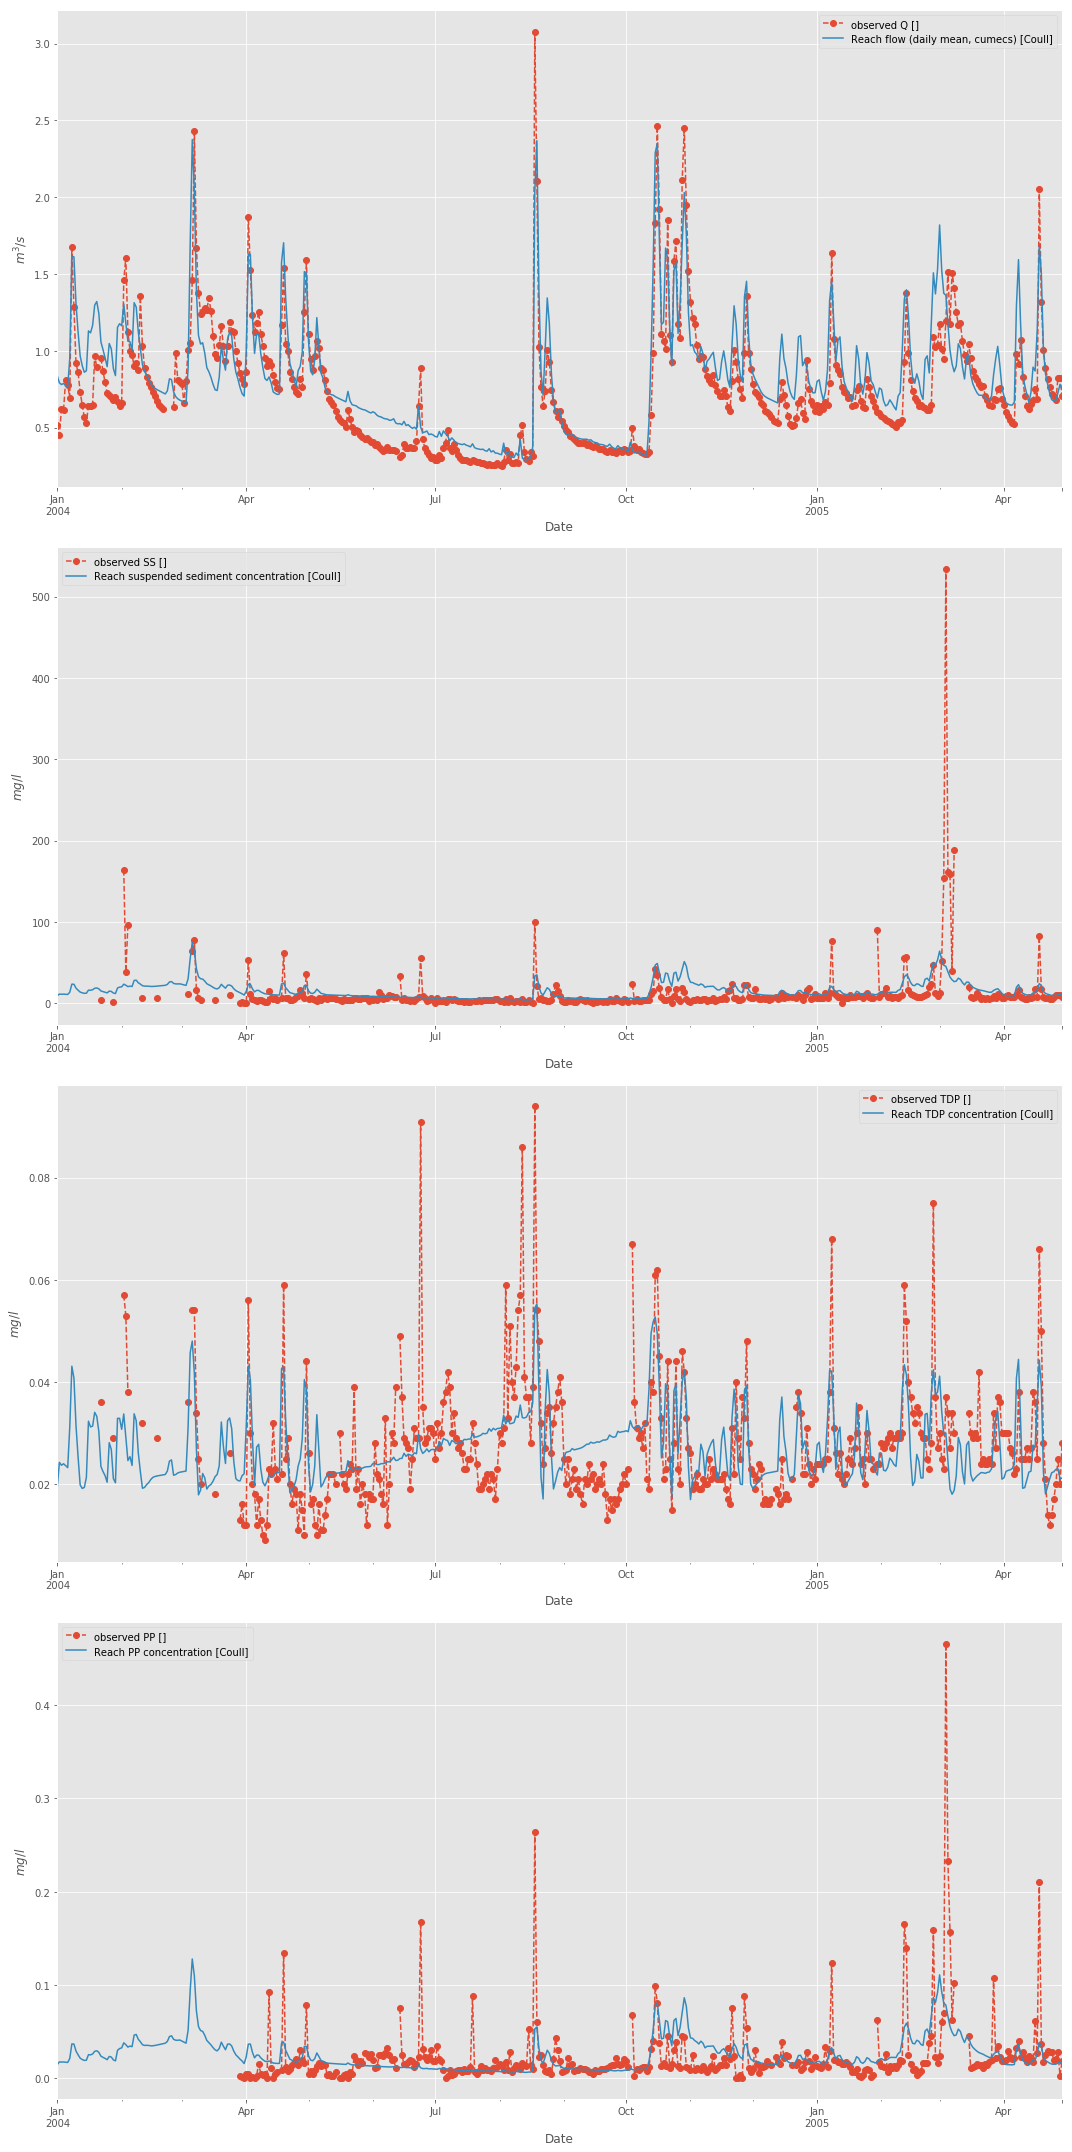

In [13]:
# Plot results from optimisation
cu.set_parameter_values(res.params, dataset)
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

Comparing the goodness-of-fit statistics from the optimiser to those from the manual calibration (section 4), you can see that the optimiser has certainly found "better" parameter sets from the point of view of the summary statistics (Nash-Sutcliffe scores etc.). However, if you look at the plots, the "by eye" fit from the manual calibration is still clearly better. This is because the optimiser is minimising the sum of squared errors - a metric that strongly penalises large outliers. The "best" result from the optimiser therefore tries to fit the peaks in the observed series, at the expense of poor fits elsewhere. Since metrics like N-S are closely related to the sum of squared errors, this approach gives impressive summary statistics, but actually rather poor simulations. The choice of appropriate summary metrics for assessing water quality time series is still an active area of research.

## 6. Full calibration and uncertainty analysis using MCMC

Bayesian MCMC provides much more comprehensive information regarding model performance, but it's also more complicated and computationally intensive. Although it's perfectly possible to begin your model analysis with MCMC, it's usually a good idea to experiment with the optimisation options described above first, and then apply MCMC as a second step.

### 6.1. Likelihood function

The (log) likelihood function describes the probability that the model, when run with a given set of parameters, will reproduce the observed data. Formulating an appropriate likelihood function is both important and challenging, and there's a lot of literature on the subject. In this example, we'll assume **heteroscedastic**, independent Gaussian errors, which is one step better than the simplest/commonest i.i.d. approach. If you'd like to know more about where this approach comes from, see [here](http://jamessample.github.io/enviro_mod_notes/) (especially [section 2 of notebook 6](https://nbviewer.jupyter.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/06_Beyond_Metropolis.ipynb#2.-Choosing-a-likelihood-function)).

In order to run parallelised MCMC, you need to create a separate Python file similar to `simplyp_calib_uncert.py`. This file defines your log likelihood function and provides the Mobius `dataset` as a "top-level object", which makes it amenable to parallel processing.

**To do**

 * See if we can figure out parallelisation from within Jupyter?

### 6.2. Error terms

Using a formal statistical likelihood involves estimating some additional error terms. We'll assume that the error distribution for all three phosphorus species is the same, so we need three terms in total (for Q, SS and P). These can be added to the result obtained from the optimiser in section 5, above.

**Note:** Names for error terms **must** begin with `err_`. Conversely, short names for model parameters **must not** begin with `err_`.

In [14]:
# Add error params
res.params.add(lmfit.Parameter('err_q', value=0.5, min=0.05, max=3, user_data={}))
res.params.add(lmfit.Parameter('err_ss', value=0.5, min=0.05, max=5, user_data={}))
res.params.add(lmfit.Parameter('err_p', value=0.5, min=0.05, max=2, user_data={}))

res.params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name         Value      Min      Max     Vary
BFI         0.7491      0.1      0.8     True
DDFmelt      4.166      0.5        5     True
E_PP         1.247        1        4     True
TDP_gw     0.01435    0.001     0.03     True
TDP_sw     0.08726     0.05      0.2     True
TDPeff       0.467     0.05      3.5     True
T_gw         103.5       15      200     True
Ts_SN        3.979        1       15     True
alphaPET    0.9151      0.5      1.5     True
err_p          0.5     0.05        2     True
err_q          0.5     0.05        3     True
err_ss         0.5     0.05        5     True
fquick    0.009024    0.002      0.2     True
k_sed        14.68        1      100     True


We also need to define a dictionary matching each of the observed data series in `comparisons` to the appropriate error term.

**Note:** The `user_data={}` is required. This dictionary will be updated after the MCMC to contain the median and MAP parameter estimates.

In [15]:
## Link error params to model datasets for Morsa
#error_param_dict = {'Observed Q':          'err_q',
#                    'Observed SS at Kure': 'err_ss',
#                    'Observed TP at Kure': 'err_p',
#                    'Observed TDP at Kure':'err_p',
#                    'Observed PP at Kure': 'err_p',
#                   }

# Link error params to model datasets for Tarland
error_param_dict = {'observed Q':  'err_q',
                    'observed SS': 'err_ss',
                    'observed TDP':'err_p',
                    'observed PP': 'err_p',
                   }

**Note:** LMFit parameter objects provide additional features for linking and combining parameters using the `expr` argument - see [here](https://lmfit.github.io/lmfit-py/constraints.html) for further details. The error terms for TDP and PP could equally well have been defined as follows:

    # Add error params
    res.params.add('err_q', value=0.5, min=0.05, max=3, user_data={})
    res.params.add('err_ss', value=0.5, min=0.05, max=5, user_data={})
    res.params.add('err_tp', value=0.5, min=0.05, max=2, user_data={})
    res.params.add('err_tdp', expr='err_tp', user_data={})             # Use a single error term for all P types
    res.params.add('err_pp', expr='err_tp', user_data={})              # Use a single error term for all P types 
    
Although not necessary here, this kind of syntax is especially useful when dealing with parameters representing proportions, where the total need to be constant.

### 6.3. MCMC options

In order to run the MCMC in parallel, all the settings from above are added to a dictionary and "pickled". Some additional options are specified below.

In [16]:
# emcee setup
nworkers = 32   # Number of cores/processes for parallelisation
ntemps = 1      # Number of temperatures for parallel tempering (use 1 for default ensemble sampler)
nsteps = 1000   # Number of steps per chain
nwalk = 100     # Number of chains/walkers
nburn = 500     # Number of steps to discard as burn-in
thin = 1        # Keep only every 'thin' steps to reduce chain auto-correlation

# Chain initialisation
# 'uniform' => Chain starting locations sampled uniformly from prior
# 'optimum' => Chain starting locations sampled from a small Gaussian ball in vicinity of optimum
init_chains = 'uniform'  # Or 'optimum'. 

skip_timesteps = 30  # Number of time steps to skip before calulating fit

# Result file paths
result_path = r'results/mcmc_results.pkl'
chain_plot_path = r'results/chains.png'
corner_plot_path = r'results/corner.png'

In [17]:
# Save settings for passing to MCMC
settings_dict = {'params':res.params,
                 'error_param_dict':error_param_dict,
                 'comparisons':comparisons,
                 'skip_timesteps':skip_timesteps,
                 'nworkers':nworkers,
                 'ntemps':ntemps,
                 'nsteps':nsteps,
                 'nwalk':nwalk,
                 'nburn':nburn,
                 'thin':thin,
                 'init_chains':init_chains,
                 'result_path':result_path,
                 'chain_path':chain_plot_path,
                 'corner_path':corner_plot_path,                 
                }

with open('results/mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

### 6.4. Run MCMC

**Important note:** Before running the code below, it is important to check the dataset paths in `simplyp_calib_uncert.py` **lines 62 and 63** to make sure they match your catchment of interest (i.e. Morsa or Tarland). At present, these paths cannot be passed "dynamically" using the dictionary above, as this breaks parallelisation of the MCMC (see section 6.1, above). We hope to fix this eventually, but for the present these dataset paths must be hard-coded. The lines to edit look like this

    dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/XXXX/XXXXParameters_v0-3.dat', 
                                                              '../../Applications/SimplyP/XXXX/XXXXInputs.dat')
                                                              
and the four occurrences of `XXXX` should be replaced with either `Tarland` or `Morsa`.

Time elapsed running emcee: 81.05 minutes.

Quantiles:
[(0.025, 1.2498598751216468), (0.5, 1.389138729678478), (0.975, 1.7156648370695218)]
Quantiles:
[(0.025, 0.02660132987499807), (0.5, 0.037356488089447706), (0.975, 0.04941464803675774)]
Quantiles:
[(0.025, 0.9277670758666299), (0.5, 0.948499229563314), (0.975, 0.9643706578379596)]
Quantiles:
[(0.025, 0.6341636507554113), (0.5, 0.6681242978692963), (0.975, 0.6975909893731501)]
Quantiles:
[(0.025, 106.16339012165204), (0.5, 118.54828742968326), (0.975, 134.10857524372375)]
Quantiles:
[(0.025, 4.454846510169684), (0.5, 5.95040489984804), (0.975, 8.635126220281027)]
Quantiles:
[(0.025, 10.025809749353463), (0.5, 11.810205012960827), (0.975, 13.506834627477078)]
Quantiles:
[(0.025, 0.052189280399330185), (0.5, 0.05965654628454278), (0.975, 0.06886024834230033)]
Quantiles:
[(0.025, 0.006440884602408914), (0.5, 0.011358710134777256), (0.975, 0.01652768388581596)]
Quantiles:
[(0.025, 2.091952463313409), (0.5, 2.4465664380089724), (0.975, 2

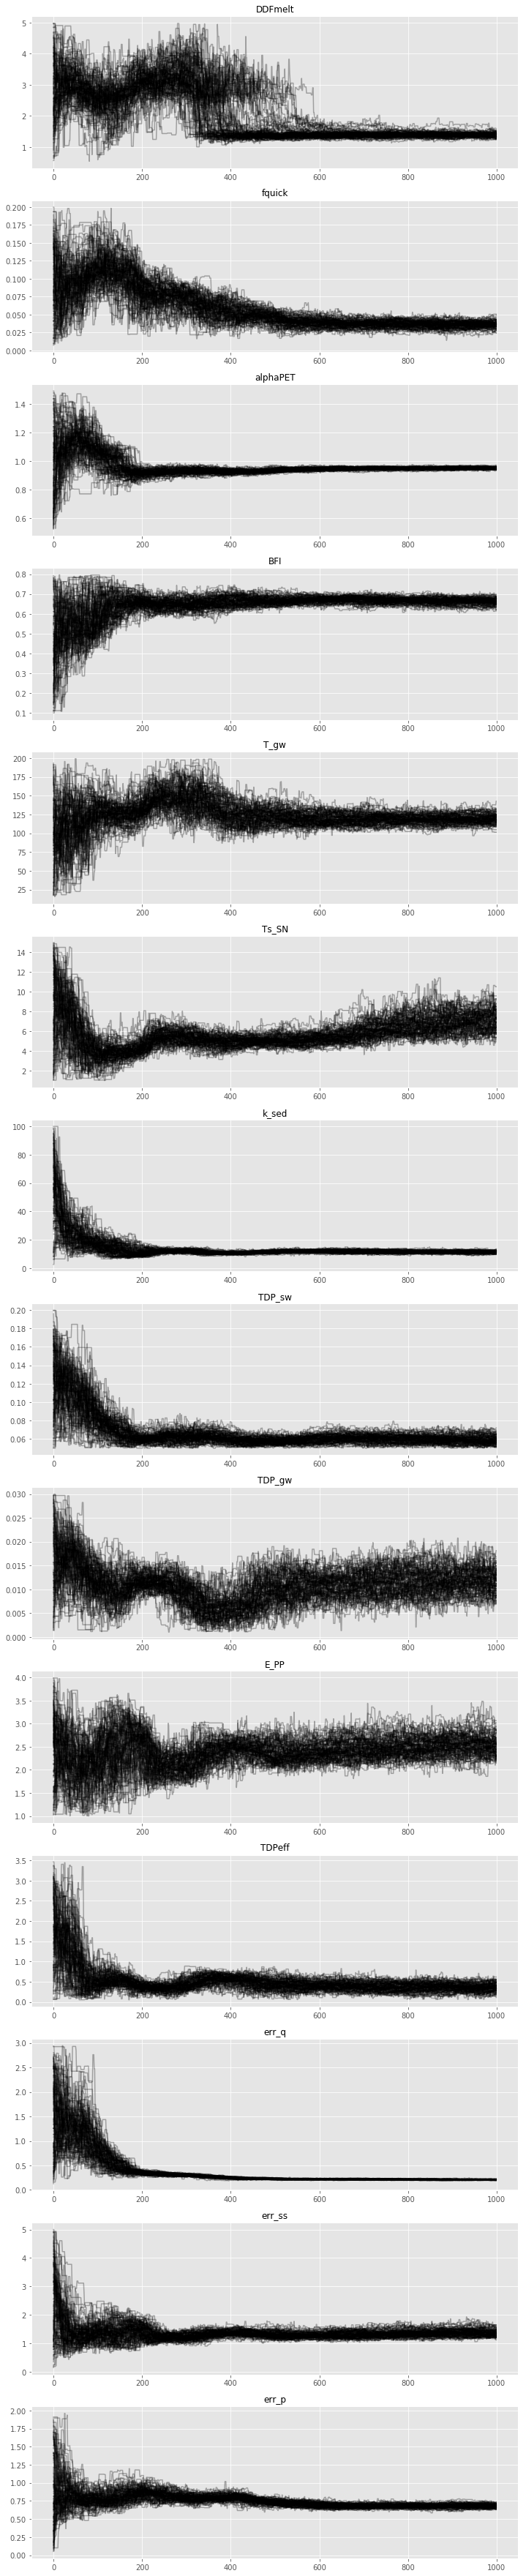

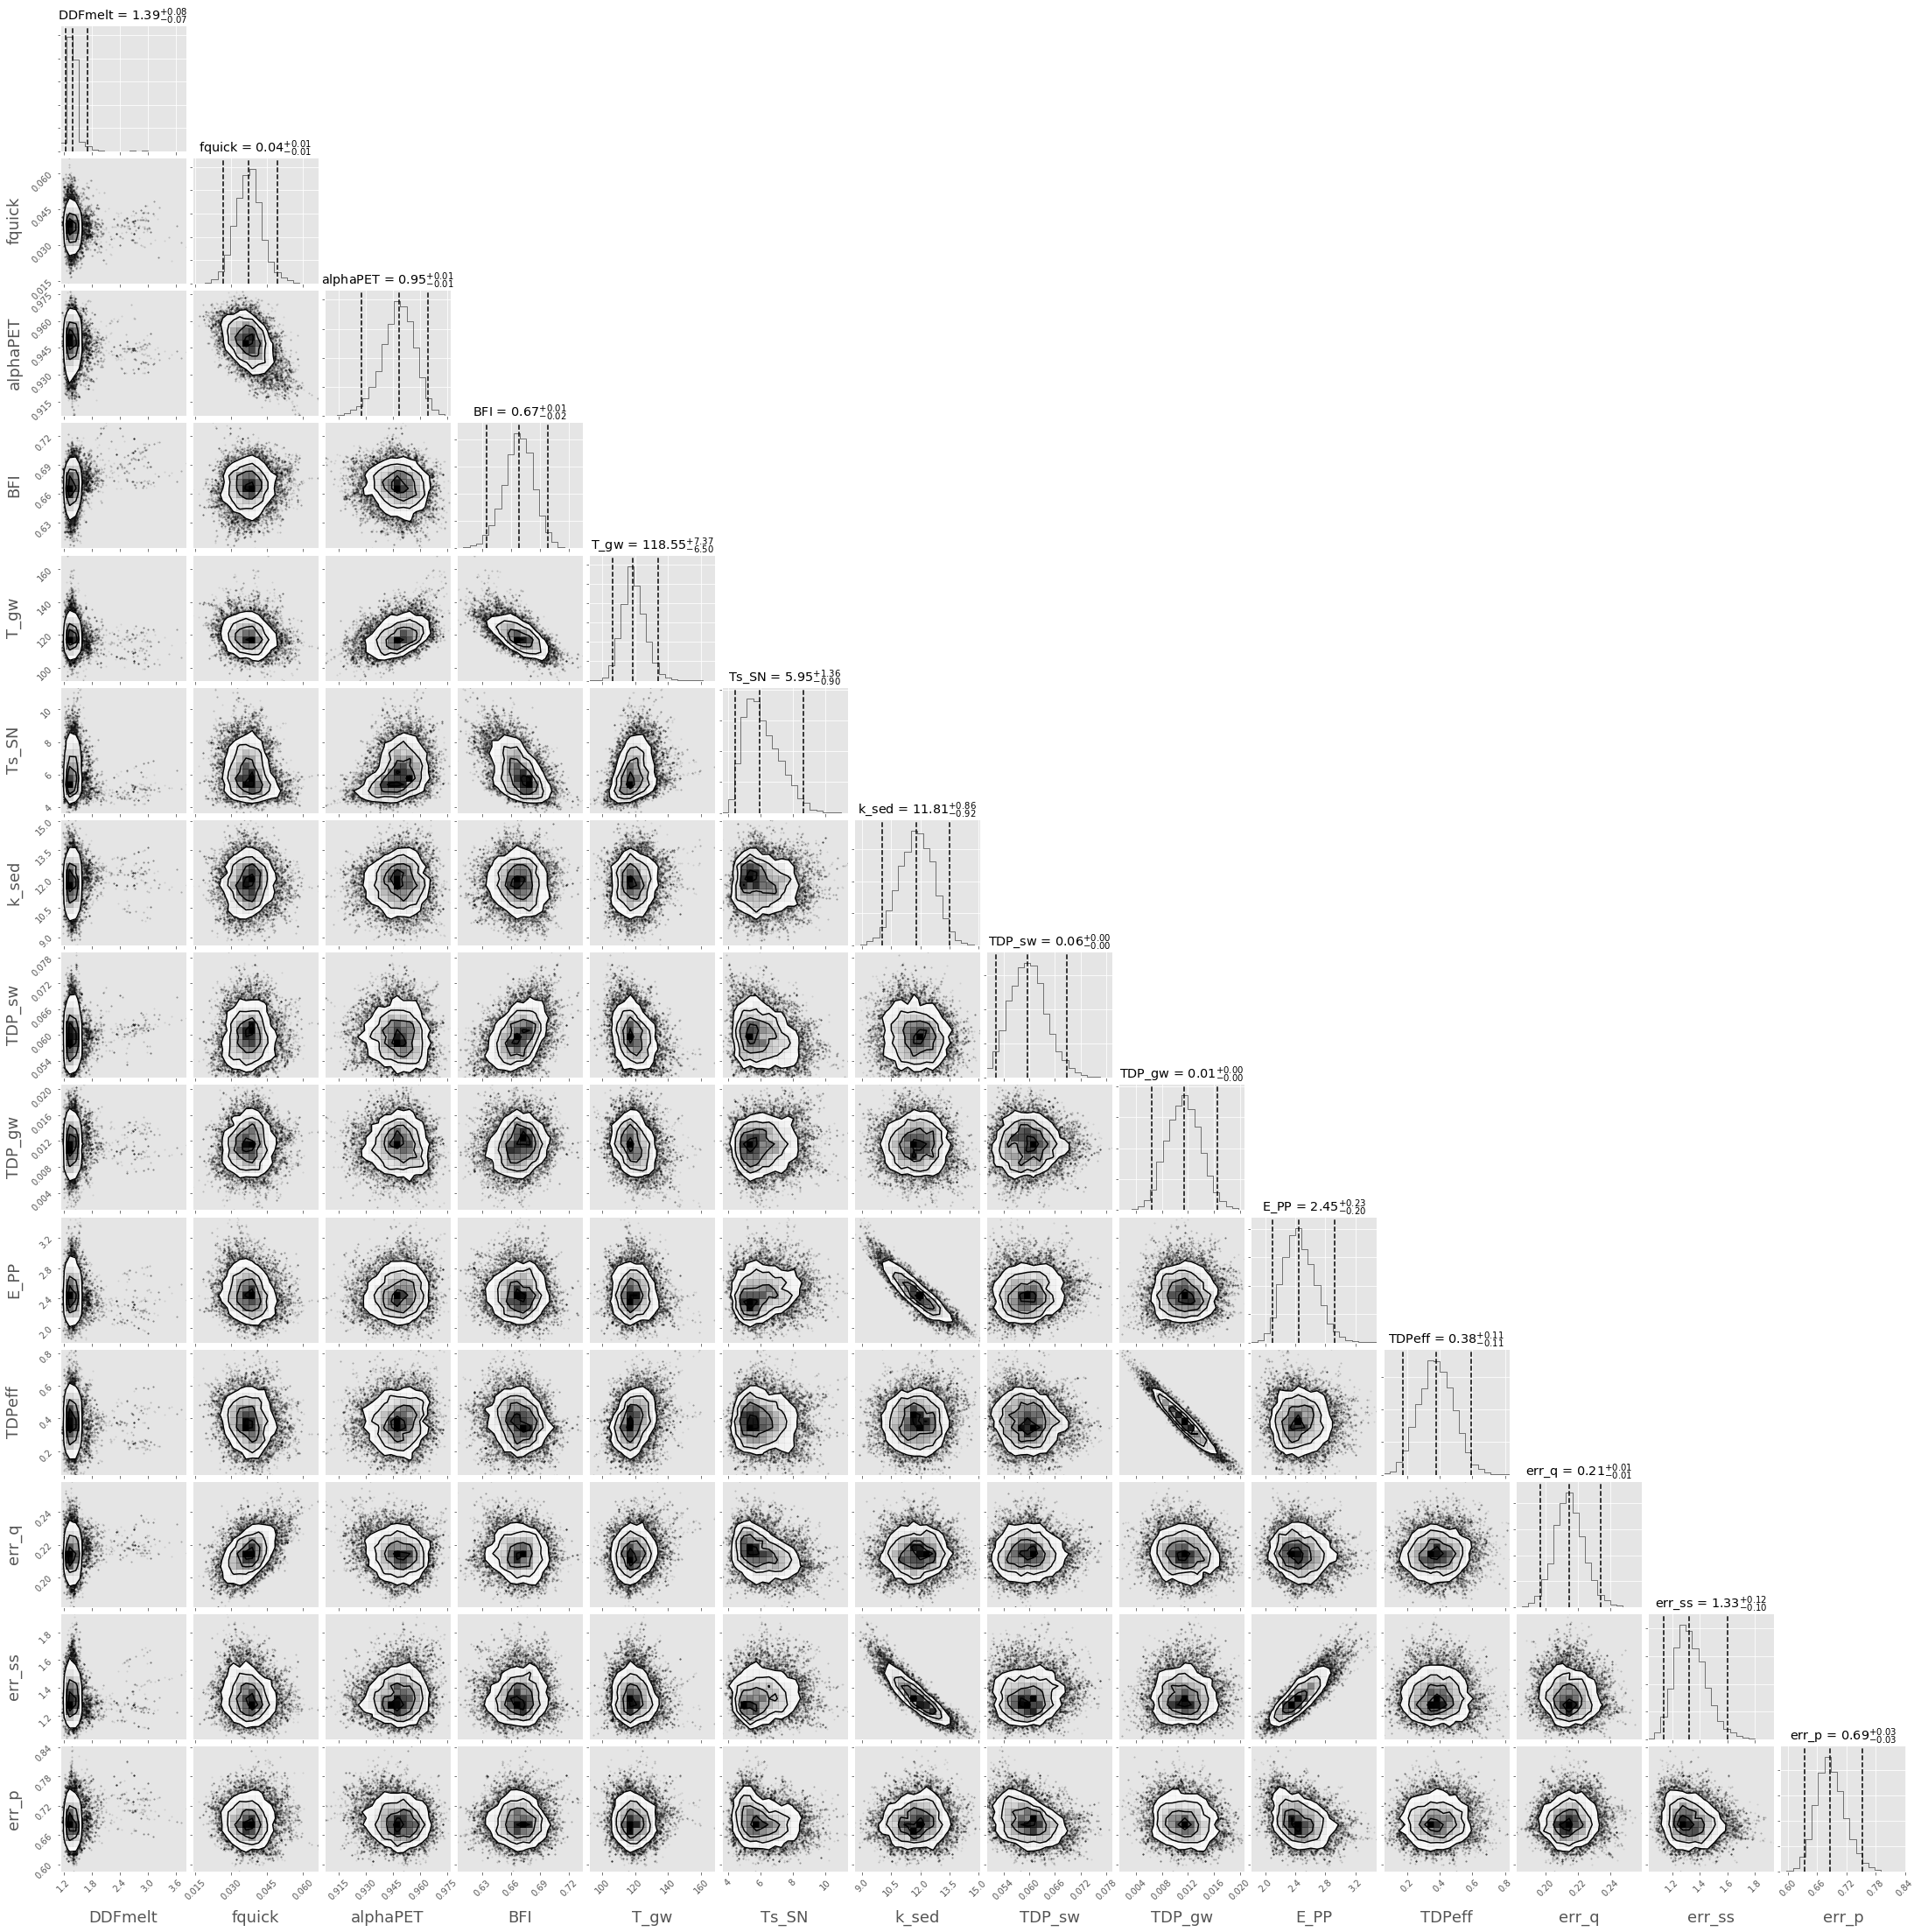

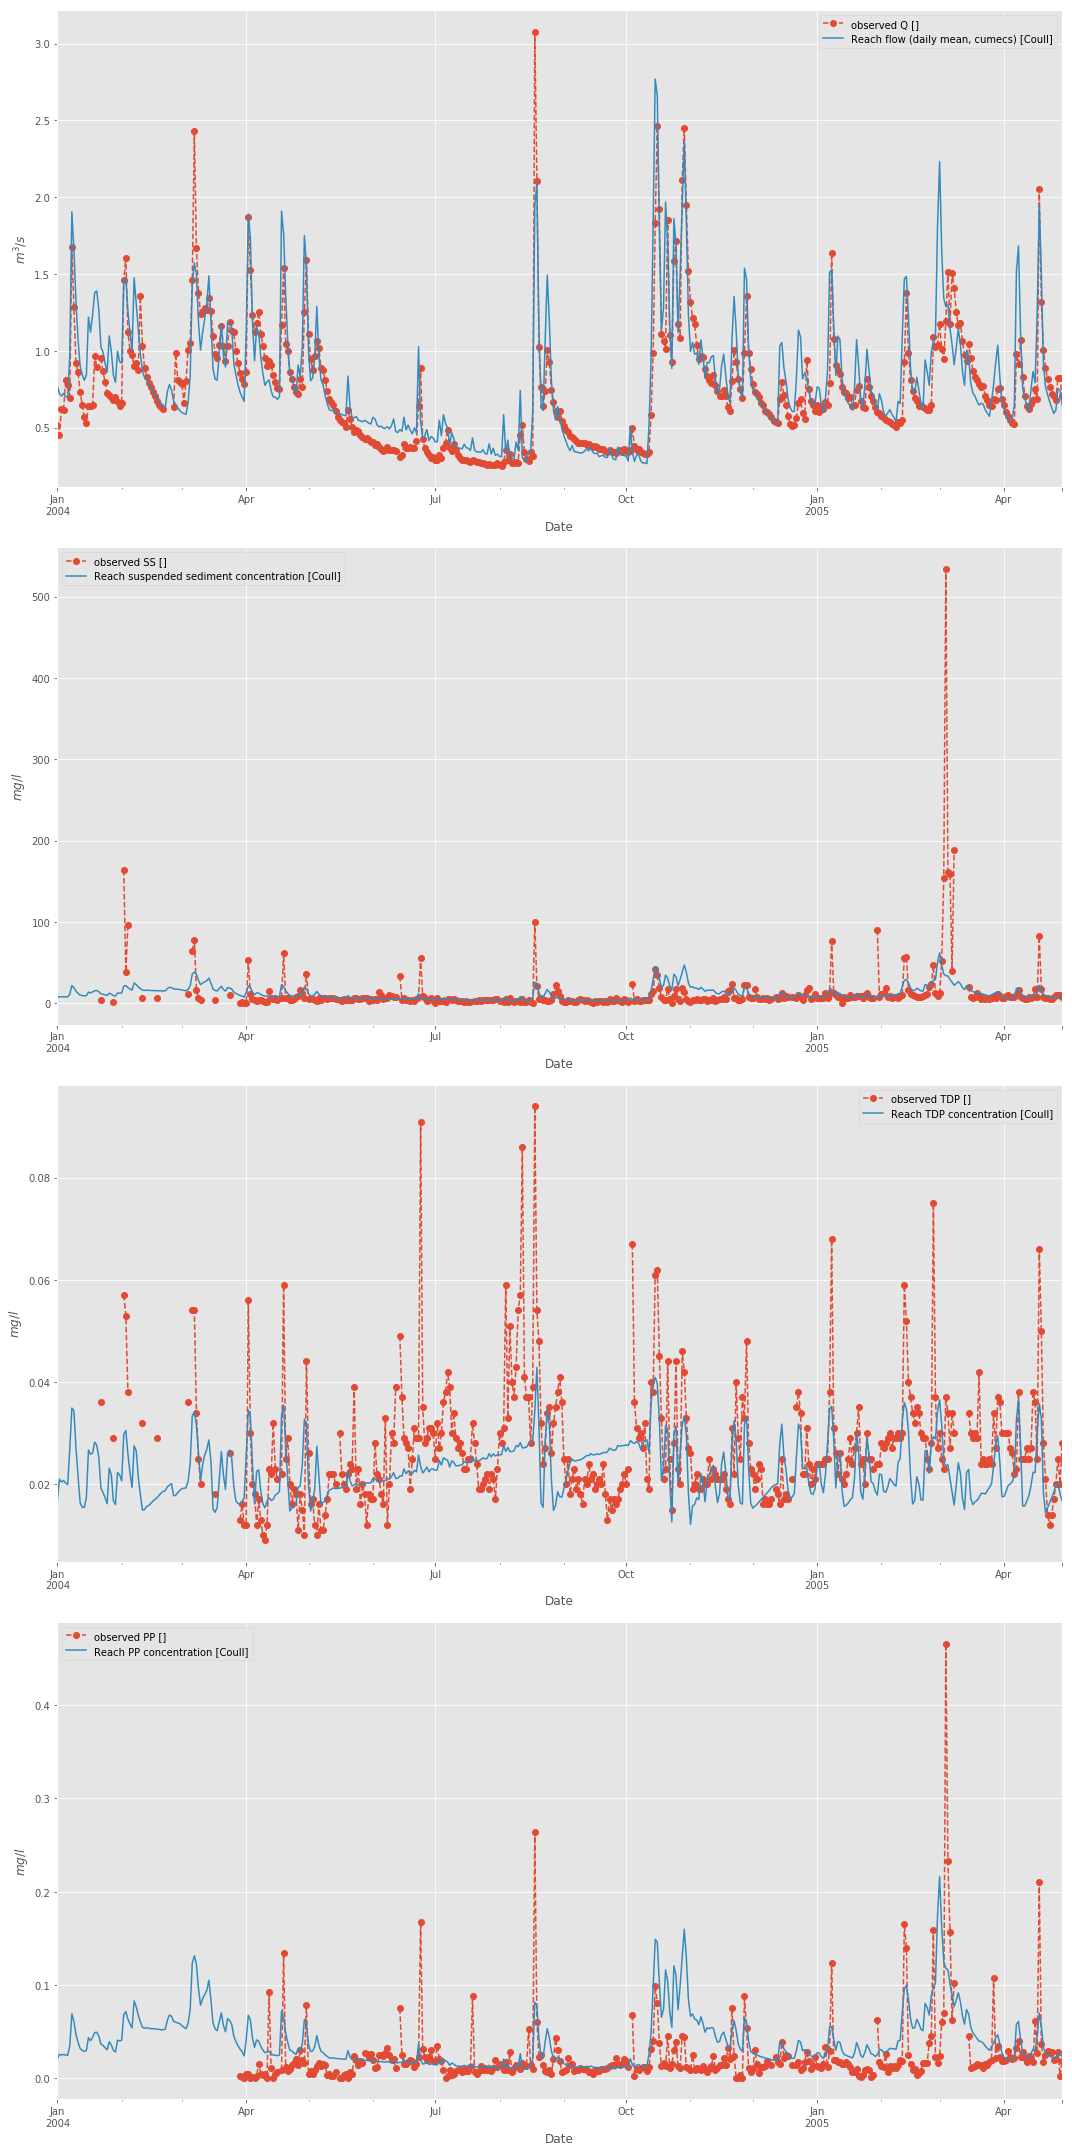

In [18]:
%run -i simplyp_calib_uncert.py

There is a lot of information on these plots, which will not be considered in detail here. Perhaps the first thing to note, though, is that the goodness-of-fit statistics from the "best" (i.e. MAP) parameter set are slightly worse than from the optimiser, but the "by eye" fit based on the time series plots is a bit better. This is largely because of our choice of likelihood function: the optimiser is minimising the sum of squared errors, which is very closely related to several of the summary statistics (like the Nash-Sutcliffe efficiency) that heavily penalises outliers. The optimiser therefore scores very well in terms of summary statistcs but, from a practical perspective, the simulations put too much emphasis on fitting "extreme" events at the expense of typical conditions. The *heteroscedastic* MCMC likelihood attempts to compensate for this to some extent by permitting larger errors during extreme events, thereby penalising outliers less harshly and giving a better overall fit. The summary statistical scores are slightly lower, however, because we're no longer targeting *exactly* the metrics being evaluated. 

Secondly, the chain plots show that the algorithm has converged fairly well by step 500 i.e. the portion of the chains after the burn-in period should provide a reasonable representation of the posterior distribution. There is some evidence of the chains clustering towards the limits of the prior distributions, which might be a reason to expand some of the prior ranges and try again (but this should only be done if it is physically reasonable to do so).

The triangle plot contains lots of useful information, including **margin posterior distributions** for each parameter (with medians and 95% credible intervals marked by vertical dashed lines), and contour plots illustrating interesting parameter **interactions** (e.g. between `E_PP` and `ksed`).

It is worth taking a moment to explore the MCMC result object, which was saved to `results/mcmc_results.pkl`, as specified above.

In [19]:
# Read MCMC results
with open('results/mcmc_results.pkl', 'rb') as handle:
    result = pickle.load(handle)

The `result` object contains the MCMC chains and log-posterior probabilities for each model evaluation (***before*** any burning and thinning).

In [20]:
# Chains. (nwalk, nsteps, npars)
print(result.chain.shape)

# Log-posterior prob. (nwalk, nsteps)
print(result.lnprob.shape)

(100, 1000, 14)
(100, 1000)


The `result.params` object stores the **median** of the marginal posterior for each parameter (***after*** discarding the burn-in and thinning), plus a 1-sigma estimate of the standard error calculated as half the difference between the 15.8 and 84.2 percentiles. These median estimates should be the same as those shown on the triangle plot, but note that the triangle shows the 95% CI instead of the standard error i.e. the 2.5 and 97.5 percentiles.

The median of the marginal posteriors is just one estimate of the "best" parameters from the MCMC; another is the maximum of the posterior distribution (the MAP). Both median and MAP parameter values are stored in the `user_data` attribute of the result object and can be accessed as shown below.

In [21]:
print(f'par         median         map')
for name in result.var_names:
    med = result.params[name].user_data['median']
    max_prob = result.params[name].user_data['map']
    print(f'{name:<10}{med:8.2f}    {max_prob:8.2f}')

par         median         map
DDFmelt       1.39        1.43
fquick        0.04        0.03
alphaPET      0.95        0.95
BFI           0.67        0.66
T_gw        118.55      120.81
Ts_SN         5.95        7.18
k_sed        11.81       11.58
TDP_sw        0.06        0.06
TDP_gw        0.01        0.01
E_PP          2.45        2.51
TDPeff        0.38        0.37
err_q         0.21        0.20
err_ss        1.33        1.34
err_p         0.69        0.68


In many cases - as here - the median and MAP estimates are similar, but this should not be expected in general.

### 6.5. Parameter and predictive uncertainty

**To do**

 * Add function to `'mobius_calib_uncert_lmfit.py'` to sample from posterior and create time series showing parameter and predictive uncertainty